In [13]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import requests
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

### Table of Contents:
1. <a href="#item1">Part 1</a>

2. <a href="#item2">Part 2</a>

3. <a href="#item3">Part 3</a>    

<a id='item1'></a>
# Part 1

### Get the Data
I will use BeautifulSoup to get the data:

In [41]:
# Use BeautifulSoup and get the table from url:
url='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
source = requests.get(url).text
soup = BeautifulSoup(source,'lxml')
table = soup.find('table')

### Pre-processing:
#### Create a function that:    
   - Split each item in the table into 3 different values: 
       - postal
       - borough 
       - neighborhood
   - Verify, format and add these values into the Dataframe df

In [42]:
def add_to_database(item):    
    if len(item) == 2:
        item=item[0]
    #get Pastal Code, the 1st 3 characters of the string:
    postal  = item[:3]    
    #initializa borough and neigh to 'NA':
    borough = 'NA'
    neighb  = 'NA'
    #Verify if we have a parentesis (neighborhoods were between paranthesis before wikipedia's update):
    if ("(" in item):
        item = item.split("(")
        #update neighborhood (between paranthesis):
        borough = item[0][3-len(item[0]):]
        # replace '/' with ',' and ')' with nothing:
        neighb  = item[1].replace(" /", ",").replace("/", ",").replace(")", "")
    else:
        #If there is no parenthesis, then we only have to update borough
        borough = item[3-len(item):]
    if neighb  == 'NA':
        neighb = borough        
    #Add postal, borough and neighborhood to dataframe: 
    global df
    if borough.upper() != 'NOT ASSIGNED' and borough != 'NA':
         df = df.append({'PostalCode': postal,
                         'Borough': borough,
                         'Neighborhood': neighb}, ignore_index=True)

#### Create a list to receive items from table:
The code below was much simpler, but wikipedia uptated the webpage and modified the table layout. Since i did not want to modify the function "add_to_database" above, i did some changes in the code below, to read and transform the data in the old wikipedia table layout!

In [44]:
list=[]
j=0
for row in table.find_all('tr'):
    old_cell_format=''
    i=0
    j=j+1
    if j != 1:
        for cell in row.find_all('td'):        
            i=i+1
            celtxt = cell.text.replace('\n','')
            if i != 3:
                old_cell_format=old_cell_format + celtxt
            else:
                if len(celtxt) > 0:                    
                    old_cell_format=old_cell_format + '(' + celtxt + ')'
        list.append(old_cell_format)    
list[0:10]


['M1ANot assigned',
 'M2ANot assigned',
 'M3ANorth York(Parkwoods)',
 'M4ANorth York(Victoria Village)',
 'M5ADowntown Toronto(Regent Park / Harbourfront)',
 'M6ANorth York(Lawrence Manor / Lawrence Heights)',
 "M7ADowntown Toronto(Queen's Park / Ontario Provincial Government)",
 'M8ANot assigned',
 'M9AEtobicoke(Islington Avenue)',
 'M1BScarborough(Malvern / Rouge)']

#### Call function add_to_database to populate the database:

In [45]:
df = pd.DataFrame(columns=['PostalCode','Borough','Neighborhood'])
for item in list:
    add_to_database(item)              
df.head(10)

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
5,M9A,Etobicoke,Islington Avenue
6,M1B,Scarborough,"Malvern, Rouge"
7,M3B,North York,Don Mills
8,M4B,East York,"Parkview Hill, Woodbine Gardens"
9,M5B,Downtown Toronto,"Garden District, Ryerson"


In [40]:
df.shape

(103, 3)

<a id='item2'></a>
# Part 2

### Get Latitudes and Longitudes from CSV file:

In [46]:
lat_lng = pd.read_csv('Geospatial_Coordinates.csv')
#set index to Postal Code to make things easier:
lat_lng.set_index('Postal Code', inplace=True)

### Update Database with Latitudes and Longitudes:

In [47]:
for i,row in df.iterrows():    
    df.at[i,'Latitude']  = lat_lng.loc[ row['PostalCode'] ][0]
    df.at[i,'Longitude'] = lat_lng.loc[ row['PostalCode'] ][1]
df.head(10)

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
5,M9A,Etobicoke,Islington Avenue,43.667856,-79.532242
6,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
7,M3B,North York,Don Mills,43.745906,-79.352188
8,M4B,East York,"Parkview Hill, Woodbine Gardens",43.706397,-79.309937
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937


<a id='item3'></a>
# Part 3

### Filter Dataframe, select boroughs that contain the word Toronto: 

In [48]:
filter='Toronto'
dft = df[df['Borough'].str.contains(filter)]
dft.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
15,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
19,M4E,East Toronto,The Beaches,43.676357,-79.293031


In [235]:
#Number of rows in dft ( = number of Neighborhoods)
dft.shape[0]

39

### Credentials to access Foursquare:

In [1]:
CLIENT_ID = '###' # your Foursquare ID
CLIENT_SECRET = '###' # your Foursquare Secret
VERSION = '###' # Foursquare API version
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 800 # define radius

### Function to get venues from Forsquare:

In [78]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

### Get venues from Foursquare, and store into toronto_venues:

In [79]:
toronto_venues = getNearbyVenues(names=dft['Neighborhood'],latitudes=dft['Latitude'],longitudes=dft['Longitude'])

Regent Park, Harbourfront
Queen's Park, Ontario Provincial Government
Garden District, Ryerson
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
The Danforth West, Riverdale
Toronto Dominion Centre, Design Exchange
Brockton, Parkdale Village, Exhibition Place
India Bazaar, The Beaches West
Commerce Court, Victoria Hotel
Studio District
Lawrence Park
Roselawn
Davisville North
Forest Hill North & West
High Park, The Junction South
North Toronto West
The Annex, North Midtown, Yorkville
Parkdale, Roncesvalles
Davisville
University of Toronto, Harbord
Runnymede, Swansea
Moore Park, Summerhill East
Kensington Market, Chinatown, Grange Park
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
Rosedale
Stn A PO Boxes
St. James Town,

In [197]:
toronto_venues.shape

(1692, 7)

In [219]:
toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,"Regent Park, Harbourfront",43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,"Regent Park, Harbourfront",43.65426,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center
3,"Regent Park, Harbourfront",43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa
4,"Regent Park, Harbourfront",43.65426,-79.360636,Morning Glory Cafe,43.653947,-79.361149,Breakfast Spot


### How many venues for each neighborhood:

In [220]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Berczy Park,56,56,56,56,56,56
"Brockton, Parkdale Village, Exhibition Place",23,23,23,23,23,23
Business reply mail Processing CentrE,16,16,16,16,16,16
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",16,16,16,16,16,16
Central Bay Street,77,77,77,77,77,77
Christie,17,17,17,17,17,17
Church and Wellesley,83,83,83,83,83,83
"Commerce Court, Victoria Hotel",100,100,100,100,100,100
Davisville,34,34,34,34,34,34


### Unique categories in column "Venue Category":

In [221]:
len(toronto_venues['Venue Category'].unique())

233

### One Hot Encoding:

In [222]:
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 
toronto_onehot.head()

,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,...,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [223]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Berczy Park,0.000000,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.000000,0.000000,...,0.00000,0.00,0.017857,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
1,"Brockton, Parkdale Village, Exhibition Place",0.000000,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.000000,0.000000,...,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.043478
2,Business reply mail Processing CentrE,0.000000,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.000000,0.000000,...,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
3,"CN Tower, King and Spadina, Railway Lands, Har...",0.000000,0.0625,0.0625,0.0625,0.125,0.0625,0.125,0.000000,0.000000,...,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
4,Central Bay Street,0.000000,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.012987,0.000000,...,0.00000,0.00,0.012987,0.000000,0.000000,0.012987,0.000000,0.000000,0.00,0.012987
5,Christie,0.000000,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.000000,0.000000,...,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
6,Church and Wellesley,0.012048,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.012048,0.000000,...,0.00000,0.00,0.000000,0.000000,0.012048,0.000000,0.012048,0.012048,0.00,0.024096
7,"Commerce Court, Victoria Hotel",0.000000,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.040000,0.000000,...,0.00000,0.00,0.020000,0.000000,0.000000,0.010000,0.000000,0.000000,0.00,0.000000
8,Davisville,0.000000,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.000000,0.000000,...,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
9,Davisville North,0.000000,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.000000,0.000000,...,0.00000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000


### Number of Neighborhoods in toronto_grouped:

In [233]:
toronto_grouped.shape[0]

39

### Top 5 Venues for each Neighborhood:

In [225]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Berczy Park----
                venue  freq
0         Coffee Shop  0.09
1        Cocktail Bar  0.05
2  Seafood Restaurant  0.04
3      Farmers Market  0.04
4            Beer Bar  0.04


----Brockton, Parkdale Village, Exhibition Place----
            venue  freq
0            Café  0.13
1  Breakfast Spot  0.09
2     Coffee Shop  0.09
3   Grocery Store  0.04
4   Burrito Place  0.04


----Business reply mail Processing CentrE----
              venue  freq
0        Comic Shop  0.06
1     Auto Workshop  0.06
2              Park  0.06
3  Recording Studio  0.06
4        Restaurant  0.06


----CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport----
              venue  freq
0    Airport Lounge  0.12
1  Airport Terminal  0.12
2             Plane  0.06
3           Airport  0.06
4          Boutique  0.06


----Central Bay Street----
                venue  freq
0         Coffee Shop  0.18
1  Italian Restaurant  0.05
2     Thai Restaurant  

### Most Comon Venues:

In [226]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)    
    return row_categories_sorted.index.values[0:num_top_venues]

In [227]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Coffee Shop,Cocktail Bar,Cheese Shop,Café,Bakery,Restaurant,Beer Bar,Farmers Market,Seafood Restaurant,Shopping Mall
1,"Brockton, Parkdale Village, Exhibition Place",Café,Breakfast Spot,Coffee Shop,Yoga Studio,Gym,Pet Store,Performing Arts Venue,Nightclub,Italian Restaurant,Intersection
2,Business reply mail Processing CentrE,Park,Auto Workshop,Skate Park,Light Rail Station,Burrito Place,Spa,Farmers Market,Fast Food Restaurant,Restaurant,Recording Studio
3,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Lounge,Airport Terminal,Boat or Ferry,Sculpture Garden,Airport,Airport Food Court,Airport Gate,Airport Service,Coffee Shop,Rental Car Location
4,Central Bay Street,Coffee Shop,Italian Restaurant,Thai Restaurant,Sandwich Place,Burger Joint,Japanese Restaurant,Café,Spa,Salad Place,Bubble Tea Shop


In [236]:
neighborhoods_venues_sorted.shape[0]

39

### Cluster Neighborhoods with K-Means:
number of clusters = 10 

In [228]:
# import k-means from clustering stage
from sklearn.cluster import KMeans

# set number of clusters
kclusters = 10
toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)
# k-means clustering:
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:] 

array([8, 8, 8, 8, 2, 0, 8, 2, 8, 7, 0, 2, 6, 8, 2, 0, 8, 8, 5, 8, 1, 8,
       8, 2, 2, 8, 4, 3, 8, 8, 8, 2, 8, 2, 2, 9, 8, 2, 8])

In [229]:
kmeans.labels_.shape[0]

39

In [230]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = dft

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
indice,,,,,,,,,,,,,,,,
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,2,Coffee Shop,Park,Pub,Bakery,Theater,Café,Restaurant,Mexican Restaurant,Breakfast Spot,Hotel
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,2,Coffee Shop,Yoga Studio,Nightclub,Beer Bar,Boutique,Burger Joint,Burrito Place,Restaurant,Café,College Auditorium
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,8,Clothing Store,Coffee Shop,Cosmetics Shop,Japanese Restaurant,Middle Eastern Restaurant,Bubble Tea Shop,Italian Restaurant,Café,Restaurant,Bookstore
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,8,Coffee Shop,Café,Italian Restaurant,Restaurant,Beer Bar,Bakery,Hotel,American Restaurant,Cosmetics Shop,Cocktail Bar
4,M4E,East Toronto,The Beaches,43.676357,-79.293031,9,Health Food Store,Trail,Pub,Yoga Studio,Dessert Shop,Ethiopian Restaurant,Empanada Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant


### Vizualize Neighborhoods Clusters in folium Map:

In [232]:
# create Folium map for Toronto Neighborhoods:
map_clusters = folium.Map(location=[dft.loc[2,'Latitude'], dft.loc[2,'Longitude'] ], zoom_start=12)

# set color scheme for the clusters:
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map:
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

... and just in case the Folium image above does not show in GitHub, I captured it in a JPG format below:

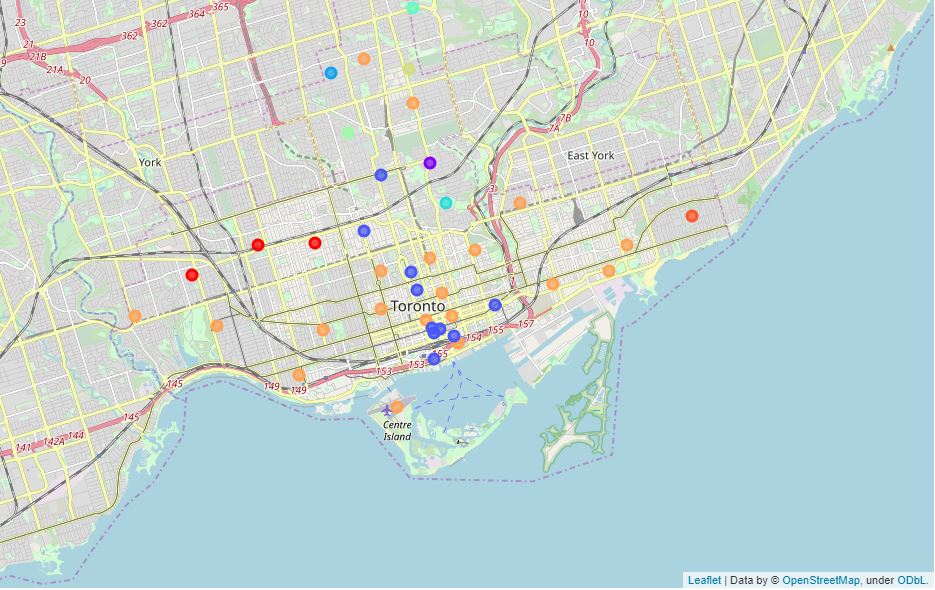

In [6]:
from IPython.display import Image
Image(filename='folium-toronto-cluster-image.jpg') 